导入相关包

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import params
import utils


%matplotlib inline


Using TensorFlow backend.


### 探索数据集

查看视频文件

shape:


(720, 1280, 3)

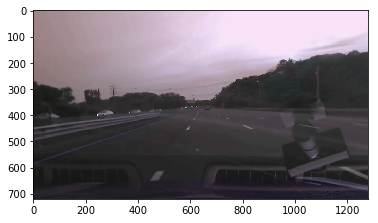

In [2]:
cap = cv2.VideoCapture(utils.join_dir(params.data_dir,"epoch01_front.mkv"))
ret, frame = cap.read()
cap.release()
plt.imshow(frame)
#shape
print('shape:')
frame.shape

查看转向数据文件

In [3]:
wheel01 = utils.fetch_csv_data(utils.join_dir(params.data_dir,"epoch01_steering.csv"))
wheel01.head(10)

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0
5,1464650070452581,5,-1.0
6,1464650070485914,6,-1.0
7,1464650070519247,7,-1.0
8,1464650070552581,8,-1.0
9,1464650070585914,9,-1.5


查看合并数据集

Records in epoch01_steering.csv : 1500
Records in epoch02_steering.csv : 3900
Records in epoch03_steering.csv : 2700
Records in epoch04_steering.csv : 2700
Records in epoch05_steering.csv : 2700
Records in epoch06_steering.csv : 2700
Records in epoch07_steering.csv : 2700
Records in epoch08_steering.csv : 2700
Records in epoch09_steering.csv : 2700
Records in epoch10_steering.csv : 2700
Total records from epoch01 to epoch10 : 27000


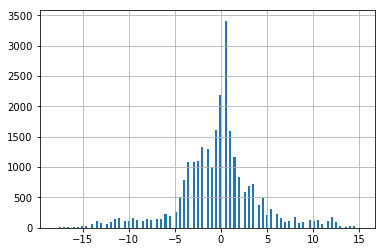

In [4]:
def get_combine_dataset(start_idx,end_idx):    
    epochs = []
    
    for i in range(start_idx,end_idx+1):
        fname='epoch{:0>2}_steering.csv'.format(i)
        epoch = utils.fetch_csv_data(utils.join_dir(params.data_dir,fname))
        print('Records in '+fname+' : '+str(len(epoch)))
        epochs.append(epoch)

    return pd.concat(epochs).wheel

def check_dataset(start_idx,end_idx):
    epoch_all = get_combine_dataset(start_idx,end_idx)
    print('Total records from epoch'+(str(start_idx).zfill(2))+' to epoch'+(str(end_idx).zfill(2))+' : '+str(len(epoch_all)))
    epoch_all.hist(bins=150)
    
check_dataset(1,10)


读取图片

Records in epoch01_steering.csv : 1500
Wheel of frame 1173 : 4.5


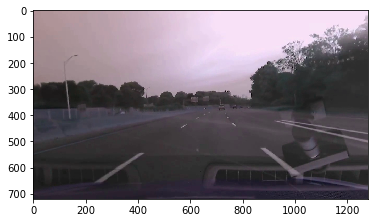

In [5]:
def show_img(img):
    plt.imshow(img)
    plt.show()
    
# load
sample_img = utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
epoch1 = get_combine_dataset(1,1)
sample_sig = epoch1[1173]
print('Wheel of frame 1173 : '+str(sample_sig))
#show
show_img(sample_img)

改变色域

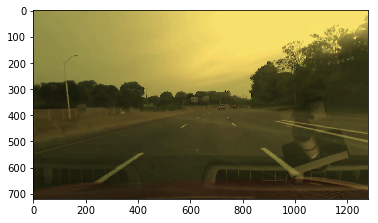

In [6]:
def change_color_space(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    img[:, :, 2] = img[:, :, 2] *np.random.uniform(0.1,1)
    return img

sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=change_color_space(sample_img)
show_img(sample_img)

平移图像

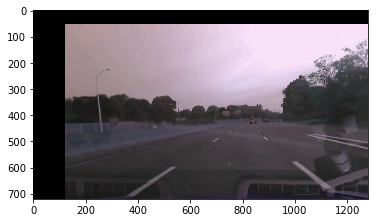

In [7]:
def translate(img):
    offset_x = np.random.uniform(1,img.shape[1]/10)
    offset_y = np.random.uniform(1,img.shape[0]/10)
    offset = np.float32([[1, 0, offset_x], [0, 1, offset_y]])
    img = cv2.warpAffine(img, offset, (img.shape[1], img.shape[0]))
    return img

sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=translate(sample_img)
show_img(sample_img)

缩放图像

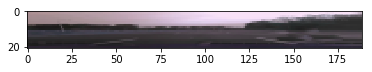

In [8]:
def resize(img):
    d_x = np.random.randint(1,200)
    d_y = np.random.randint(1,200)
    img = cv2.resize(src=img,dsize=(d_x,d_y),interpolation=cv2.INTER_AREA)

    return img

sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=resize(sample_img)
show_img(sample_img)

获取图片集合

In [40]:
def get_combine_img(start_idx,end_idx):
    imgs = []
    fc = 0
    for i in range(start_idx,end_idx+1):
        vname='epoch{:0>2}_front.mkv'.format(i)
        cap = cv2.VideoCapture(utils.join_dir(params.data_dir,vname))
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break;
            #pre-process
            frame = img_pre_process(frame)
            imgs.append(frame)
            fc = fc + 1
        cap.release()
        print("Frames in "+vname+": "+str(fc)) 
        fc = 0
        
    return imgs

def img_pre_process(img):
    img = change_color_space(img)
    img = translate(img)
    img = resize(img)
    return np.resize(img, (params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c))

分批读取数据集

In [41]:
#由于机器硬件限制,故进行分批读取1~9数据集
def load_dataset_by_batch():
    all_features = []
    all_labels = []
    print('Start to load datasets...')
    for epoch_id in range(1,2):
        print('Processing epoch{:0>2}>>>'.format(epoch_id))
        combine_features = get_combine_img(epoch_id,epoch_id)
        combine_labels = get_combine_dataset(epoch_id,epoch_id)
        all_features += combine_features
        all_labels += combine_labels.tolist()
        
    print("Done")
    print("Length of features : "+str(len(all_features))+" length of labels : "+str(len(all_labels)))
    return all_features,all_labels

all_features,all_labels = load_dataset_by_batch()

Start to load datasets...
Processing epoch01>>>
Frames in epoch01_front.mkv: 1500
Records in epoch01_steering.csv : 1500
Done
Length of features : 1500 length of labels : 1500


引入keras相关包

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten
from keras import optimizers

In [43]:
def get_nvidia_end_to_end_model():
    print("Start to create model")
    model = Sequential()
    model.add(Lambda(lambda x:x/255., input_shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c)))
    model.add(Convolution2D(24,(5,5), activation='relu', strides=(2,2), padding='valid'))
    model.add(Convolution2D(36,(5,5), activation='relu', strides=(2,2), padding='valid'))
    model.add(Convolution2D(48,(5,5), activation='relu', strides=(2,2), padding='valid'))
    model.add(Convolution2D(64,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Convolution2D(64,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mse', optimizer='Adam')
    print("Model created")
    return model


分割训练集和测试集

In [44]:
from sklearn.model_selection import train_test_split
def split_datasets(all_features,all_labels):
    print("Start to split datasets")
    
    all_features = np.array(all_features)
    all_labels = np.array(all_labels)
    all_labels = np.reshape(all_labels,(len(all_labels),1))
    
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)
    print("Split completed")
    #return combine_features,combine_labels
    return X_train, X_test, y_train, y_test


In [45]:
model = get_nvidia_end_to_end_model()
X_train, X_test, y_train, y_test = split_datasets(all_features,all_labels)
print("Split result=========================")
print("Shape of trainning set")
print(X_train.shape, y_train.shape)
print("Shape of test set")
print(X_test.shape, y_test.shape)
#json_string = model.to_json() 
#open(utils.join_dir(params.model_dir,"model.json"),'w').write(json_string)   
#model.save_weights(utils.join_dir(params.model_dir,"model.h5"))

Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(1200, 64, 64, 3) (1200, 1)
Shape of test set
(300, 64, 64, 3) (300, 1)


In [46]:
import time

def fit_model(model,epochs=10):
    fit_start = time.time()
    fitted_model=model.fit(X_train, y_train, epochs=epochs ,batch_size=256, validation_split=0.2)
    fit_end = time.time() 
    print('Training time: {}'.format(fit_end-fit_start))

    # Test the performance on test data
    test_loss= model.evaluate(X_test, y_test, batch_size=256)
    print('Test loss is:{}'.format(test_loss))
    return fitted_model

In [47]:
fitted_model = fit_model(model,epochs=10)

Train on 960 samples, validate on 240 samples
Epoch 1/10
960/960 [==============================] - 2s - loss: 10.6465 - val_loss: 11.3403
Epoch 2/10
960/960 [==============================] - 1s - loss: 10.2674 - val_loss: 11.3520
Epoch 3/10
960/960 [==============================] - 1s - loss: 10.2921 - val_loss: 11.3562
Epoch 4/10
960/960 [==============================] - 1s - loss: 10.2925 - val_loss: 11.3562
Epoch 5/10
960/960 [==============================] - 1s - loss: 10.2925 - val_loss: 11.3562
Epoch 6/10
960/960 [==============================] - 1s - loss: 10.2924 - val_loss: 11.3562
Epoch 7/10
960/960 [==============================] - 1s - loss: 10.2924 - val_loss: 11.3562
Epoch 8/10
960/960 [==============================] - 1s - loss: 10.2924 - val_loss: 11.3562
Epoch 9/10
960/960 [==============================] - 1s - loss: 10.2924 - val_loss: 11.3562
Epoch 10/10
960/960 [==============================] - 1s - loss: 10.2924 - val_loss: 11.3562
Training time: 15.66041

In [48]:
def display_fit_result(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])

    plt.ylabel('loss', fontsize=11)
    plt.xlabel('epoch', fontsize=11)
    plt.legend(['train', 'valid'], loc='best')
    plt.xlim((0,10))
    plt.xticks(np.arange(0, 11, 2))
    plt.grid()
    plt.show()

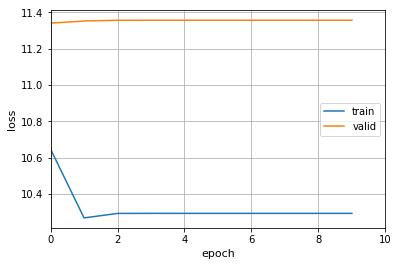

In [49]:
display_fit_result(fitted_model)

In [52]:
from keras.layers.pooling import MaxPooling2D 
from keras.layers import Dropout
def get_nvidia_end_to_end_model_2():
    print("Start to create model")
    model = Sequential()
    model.add(Lambda(lambda x:x/255., input_shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c)))
    model.add(Convolution2D(24,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Convolution2D(36,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Convolution2D(48,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Convolution2D(64,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Convolution2D(64,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='Adam')
    print("Model created")
    return model

Start to create model
Model created
Train on 960 samples, validate on 240 samples
Epoch 1/10
960/960 [==============================] - 3s - loss: 11.0323 - val_loss: 11.9974
Epoch 2/10
960/960 [==============================] - 3s - loss: 11.0356 - val_loss: 12.0119
Epoch 3/10
960/960 [==============================] - 3s - loss: 10.8421 - val_loss: 12.0079
Epoch 4/10
960/960 [==============================] - 3s - loss: 10.8252 - val_loss: 11.9987
Epoch 5/10
960/960 [==============================] - 3s - loss: 10.8067 - val_loss: 11.9890
Epoch 6/10
960/960 [==============================] - 3s - loss: 10.8103 - val_loss: 11.9794
Epoch 7/10
960/960 [==============================] - 3s - loss: 10.7355 - val_loss: 11.9692
Epoch 8/10
960/960 [==============================] - 3s - loss: 10.7703 - val_loss: 11.9582
Epoch 9/10
960/960 [==============================] - 3s - loss: 10.7653 - val_loss: 11.9442
Epoch 10/10
960/960 [==============================] - 3s - loss: 10.7582 - val_l

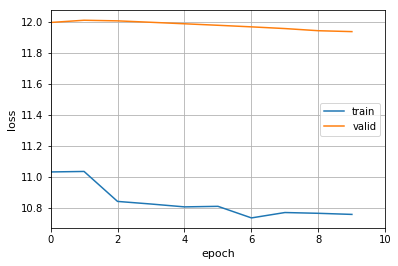

In [53]:
model = get_nvidia_end_to_end_model_2()
fitted_model = fit_model(model)
display_fit_result(fitted_model)